# Preparing data

## Import packages

In [1]:
import pandas as pd
import numpy as np
import os as os
from pathlib import Path
from datetime import datetime

## Read file

In [2]:
file_name = 'df_cleaned.pkl'
df_cleaned = pd.read_pickle(file_name)

In [3]:
df_date = df_cleaned.copy()
df_date['mm'] = df_cleaned['yyyymmdd'].dt.month
df_date['dd'] = df_cleaned['yyyymmdd'].dt.day

In [4]:
piv = df_date.pivot_table(index=['stno', 'mm', 'dd'], values=['TX01', 'PP01', 'WD01', 'WD02', 'PS01'], aggfunc='mean')
piv

PP01         PS01       TX01      WD01        WD02
stno   mm dd                                                        
466880 1  1   0.615000  1022.325000  15.620000  2.895000   70.500000
          2   0.894737  1021.100000  16.680000  2.535000   86.000000
          3   4.540000  1020.100000  17.100000  2.515000   87.500000
          4   1.155000  1019.145000  17.285000  2.165000  114.500000
          5   1.827778  1019.360000  16.965000  2.145000   91.000000
...                ...          ...        ...       ...         ...
467990 12 27  1.275000  1012.544444  11.833333  4.288889  122.222222
          28  0.670588  1012.655556  11.455556  4.066667  118.333333
          29  1.652941  1012.716667  11.716667  3.855556  135.000000
          30  2.029412  1013.955556  11.322222  4.044444  140.555556
          31  0.088235  1015.772222  10.461111  4.327778  107.777778

[12809 rows x 5 columns]

# PCA and K-means clustering

## import packages

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import preprocessing

## Preprocessing

In [6]:
# normalize
x = piv.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
scaled_data = pd.DataFrame(x_scaled)

scaled_data.fillna(0, inplace = True)

## Fitting PCA

In [7]:
pca = PCA()
scores = pca.fit_transform(scaled_data)

## Choosing the number of components

#### variance

In [8]:
pca.explained_variance_ratio_

array([0.41956229, 0.36423318, 0.11662876, 0.08747358, 0.01210219])

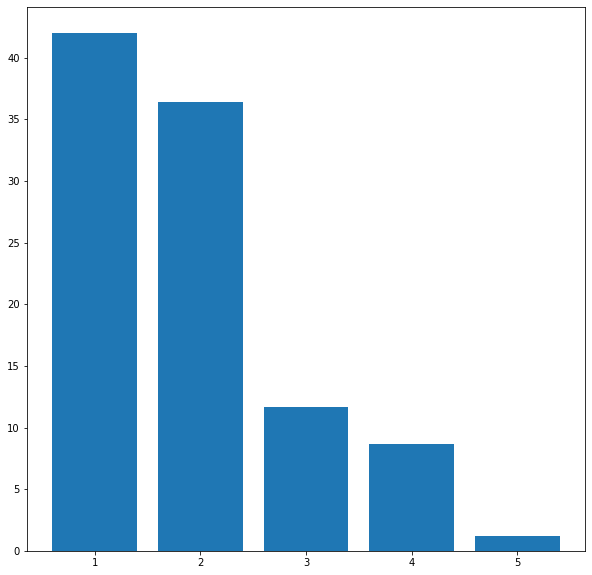

In [9]:
plt.figure(figsize=(10,10))
var = np.round(pca.explained_variance_ratio_*100, decimals = 1)
lbls = [str(x) for x in range(1,len(var)+1)]
plt.bar(x=range(1,len(var)+1), height = var, tick_label = lbls)
plt.show()

#### cumulative variance plot

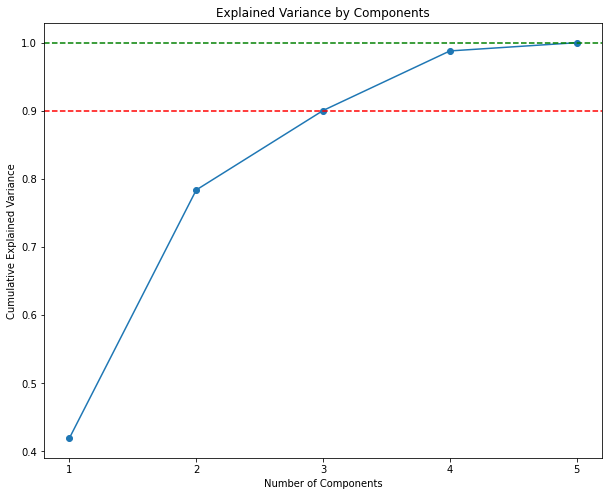

In [10]:
plt.figure(figsize=(10,8))
plt.plot(np.arange(1, 6, 1), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '-')
plt.xticks(np.arange(1, 6, 1))
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

plt.axhline(y=0.9, linestyle='--', color='r')
plt.axhline(y=1.0, linestyle='--', color='g')

4 components is the best choice.

In [28]:
pca = PCA(4)
scores_pca = pca.fit_transform(scaled_data)
scores_pca

array([[-0.12104564,  0.24415125, -0.23114117,  0.12340106],
       [-0.10546986,  0.18348231, -0.22800201,  0.1088231 ],
       [-0.10692257,  0.17375643, -0.22534386,  0.09514127],
       ...,
       [ 0.03243108,  0.22829813, -0.09062442,  0.24071003],
       [ 0.04095272,  0.23087557, -0.07136111,  0.25563457],
       [-0.00291596,  0.31811376, -0.10381663,  0.25559617]])

### Choosing the number of clusterings

In [18]:
# We fit K means using the transformed data from the PCA.
wcss = []
for i in range(1,25):
    kmeans_pca = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

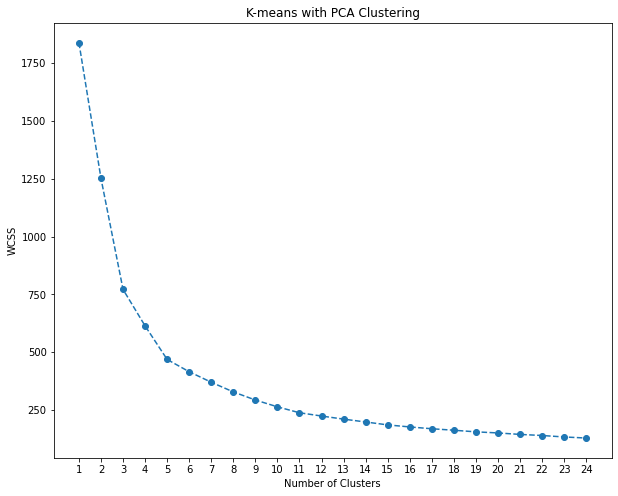

In [19]:
plt.figure(figsize= (10,8))
plt.plot(range(1, 25), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means with PCA Clustering')
plt.xticks(np.arange(1, 25, 1))
plt.show()

Using elbow method, 5 clusters is the best choice.

In [20]:
# We have chosen four clusters, so we run K-means with number of clusters equals four.
# Same initializer and random state as before.
kmeans_pca = KMeans(n_clusters = 5, init = 'k-means++', random_state = 42)

# We fit our data with the k-means pca model
kmeans_pca.fit(scores_pca)

KMeans(n_clusters=5, random_state=42)

## Results of PCA and K-Means Clustering

In [21]:
# We create a new data frame with the original features and add the PCA scores and assigned clusters.
piv_pca_kmeans = pd.concat([piv.reset_index(drop=False), pd.DataFrame(scores_pca)], axis=1)
piv_pca_kmeans.columns.values[-4: ]= ['Component 1', 'Component 2', 'Component 3', 'Component 4']
# The Last column we add contains the pca k-means clustering Labels.
piv_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_
piv_pca_kmeans

,stno,mm,dd,PP01,PS01,TX01,WD01,WD02,Component 1,Component 2,Component 3,Component 4,Segment K-means PCA
0,466880,1,1,0.615000,1022.325000,15.620000,2.895000,70.500000,-0.121046,0.244151,-0.231141,0.123401,0
1,466880,1,2,0.894737,1021.100000,16.680000,2.535000,86.000000,-0.105470,0.183482,-0.228002,0.108823,0
2,466880,1,3,4.540000,1020.100000,17.100000,2.515000,87.500000,-0.106923,0.173756,-0.225344,0.095141,0
3,466880,1,4,1.155000,1019.145000,17.285000,2.165000,114.500000,-0.062455,0.104832,-0.209409,0.112463,0
4,466880,1,5,1.827778,1019.360000,16.965000,2.145000,91.000000,-0.092107,0.153750,-0.247533,0.101186,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12804,467990,12,27,1.275000,1012.544444,11.833333,4.288889,122.222222,0.004301,0.270157,-0.076679,0.230170,0
12805,467990,12,28,0.670588,1012.655556,11.455556,4.066667,118.333333,0.008011,0.273638,-0.100981,0.235443,0
12806,467990,12,29,1.652941,1012.716667,11.716667,3.855556,135.000000,0.032431,0.228298,-0.090624,0.240710,0
12807,467990,12,30,2.029412,1013.955556,11.322222,4.044444,140.555556,0.040953,0.230876,-0.071361,0.255635,0


One small step remains: we should add the names of the segments to the labels.

In [22]:
piv_pca_kmeans['Segment'] = piv_pca_kmeans['Segment K-means PCA'].map({0: 'first', 1: 'second', 2: 'third', 3: 'fourth', 4: 'fifth'})

## Visualize Clusters by Components

/data1/home/hsnutardis/anaconda3/envs/RCEC_summer_2022/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


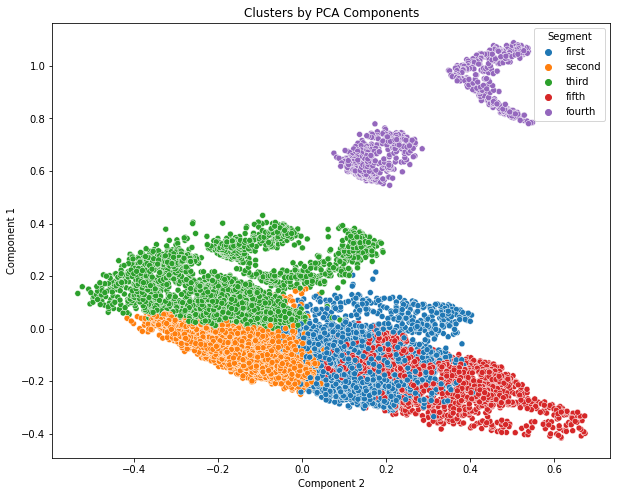

In [23]:
# PLot data by PCA components. The Y axis is the first component, X axis is the second.
x_axis = piv_pca_kmeans['Component 2']
y_axis = piv_pca_kmeans['Component 1']
plt.figure(figsize = (10,8))
sns.scatterplot(x_axis, y_axis, hue = piv_pca_kmeans['Segment']) #, palette =['g', 'r', 'c', 'm']
plt.title('Clusters by PCA Components')
plt.show()

Date and 測站

In [24]:
import matplotlib.dates as md

In [25]:
piv_pca_kmeans['date'] = (
    '2020' + '-' 
    + piv_pca_kmeans['mm'].astype('string').str.zfill(2) + '-' 
    + piv_pca_kmeans['dd'].astype('string').str.zfill(2)
)

piv_pca_kmeans['date'] = pd.to_datetime(piv_pca_kmeans['date'], format='%Y-%m-%d')


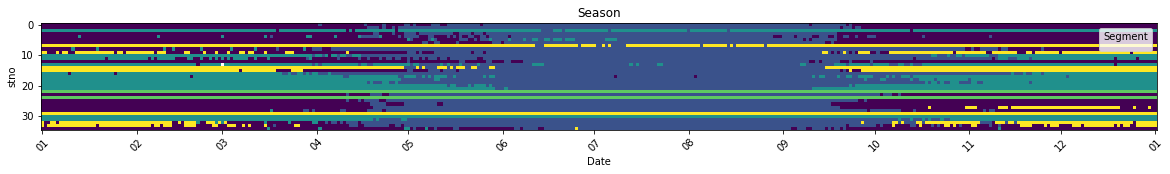

In [26]:
plotdata = piv_pca_kmeans.pivot_table(index=['stno'], columns=['date'], values=['Segment K-means PCA'])


fig, ax = plt.subplots(1, 1, figsize = (20,16))
plt.imshow(plotdata)


# Labelling 
ax.xaxis.set_major_locator(md.MonthLocator())
ax.xaxis.set_major_formatter(md.DateFormatter('%m'))

plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("stno")
plt.title("Season")
plt.legend(piv.columns, title='Segment')

plt.show()